# Libraries

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt

# for the models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor


# misc
import warnings
warnings.filterwarnings(action="ignore")
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

## Get new clean data

In [2]:
train = pd.read_csv("./train_final.csv")
test = pd.read_csv("./test_final.csv")

## Target Variable 

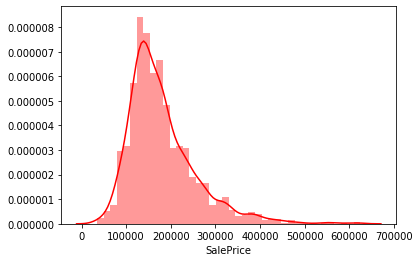

In [3]:
# our target variable is SalePrice
sns.distplot(train['SalePrice'], color='Red');

The target variable is <b>skewed right</b>. We should use a power transformation to make it evenly distributed. Powers < 1 are good for transforming data that is skewed right. This will be done in feature engineering.

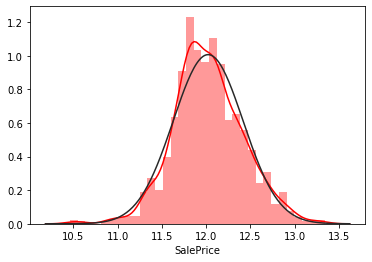

In [4]:
train["SalePrice"] = np.log1p(train["SalePrice"])
sns.distplot(train['SalePrice'], color='Red', fit=norm);

## Modeling

In [5]:
# feature scaling
#scaler = StandardScaler()
#train_columns = train.columns
#train = pd.DataFrame(scaler.fit_transform(train), columns = train_columns)

# separate predictors and prediction
y = train["SalePrice"]
X = train.drop("SalePrice", axis=1)

# k-folds
kfold = KFold(n_splits=10, random_state=0, shuffle=True)

# functions for error score
def cv_rmsle(model):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfold))
    return (rmse)


# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 0)


# alphas for Ridge and Lasso
alphas = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]

# df with each score to make a comparison plot later
d = {'Model': [], 'Score': []}
model_scores_df = pd.DataFrame(data=d)

##### Multiple Linear Regression

In [6]:
lm = LinearRegression()
lm.fit(X_train, y_train)

# Predict test data. 
y_pred = lm.predict(X_test)

print('R^2: %.4f' %(lm.score(X_test, y_test)))

print("-"*70)

# CV
score = cv_rmsle(LinearRegression())
print("CV LM RMSE: {:.4f}".format(score.mean()))


# insert into model_scores_df
model_scores_df = model_scores_df.append({'Model': 'MLR', 'Score': score.mean()}, ignore_index=True)

R^2: 0.9148
----------------------------------------------------------------------
CV LM RMSE: 0.1229


In [7]:
model_scores_df

,Model,Score
0,MLR,0.122894


##### Ridge

In [8]:
temp_rss = {}
temp_mse = {}
for i in alphas:
    ## Assigin each model. 
    ridge = Ridge(alpha= i, normalize=True)
    ## fit the model. 
    ridge.fit(X_train, y_train)
    ## Predicting the target value based on "Test_x"
    y_pred = ridge.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    temp_mse[i] = rmse

for key, value in sorted(temp_mse.items(), key=lambda item: item[1]):
    print("%s: %s" % (key, value))

print("-"*70)

# CV
score = cv_rmsle(Ridge())
print("CV Ridge RMSE: {:.4f}".format(score.mean()))


# insert into model_scores_df
model_scores_df = model_scores_df.append({'Model': 'Ridge', 'Score': score.mean()}, ignore_index=True)

0.01: 0.11135747429512871
0.001: 0.11204601790180016
0.0001: 0.11309034896645209
1e-08: 0.1132655276751986
1e-10: 0.11326569281743419
1e-15: 0.11329505600746212
1: 0.13213298442072405
5: 0.18629187553823393
10: 0.22788133577493094
20: 0.27448666180345294
----------------------------------------------------------------------
CV Ridge RMSE: 0.1209


##### Lasso

In [9]:
temp_rss = {}
temp_mse = {}
for i in alphas:
    ## Assigin each model. 
    lasso = Lasso(alpha= i, normalize=True)
    ## fit the model. 
    lasso.fit(X_train, y_train)
    ## Predicting the target value based on "Test_x"
    y_pred = lasso.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    temp_mse[i] = rmse

for key, value in sorted(temp_mse.items(), key=lambda item: item[1]):
    print("%s: %s" % (key, value))

print("-"*70)

# CV
score = cv_rmsle(Lasso())
print("CV Lasso RMSE: {:.4f}".format(score.mean()))


# insert into model_scores_df
model_scores_df = model_scores_df.append({'Model': 'Lsso', 'Score': score.mean()}, ignore_index=True)

0.0001: 0.11047805913808915
1e-08: 0.11431006284124334
1e-10: 0.11432820886981129
1e-15: 0.1143283906211756
0.001: 0.1477673511282176
0.01: 0.38976824255161446
1: 0.38976824255161446
5: 0.38976824255161446
10: 0.38976824255161446
20: 0.38976824255161446
----------------------------------------------------------------------
CV Lasso RMSE: 0.2217


##### ElasticNet

In [10]:
temp_rss = {}
temp_mse = {}
for i in alphas:
    ## Assigin each model. 
    elast = ElasticNet(alpha= i, normalize=True)
    ## fit the model. 
    elast.fit(X_train, y_train)
    ## Predicting the target value based on "Test_x"
    y_pred = elast.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    temp_mse[i] = rmse
    
for key, value in sorted(temp_mse.items(), key=lambda item: item[1]):
    print("%s: %s" % (key, value))

print("-"*70)

# CV
score = cv_rmsle(ElasticNet())
print("CV ElasticNet RMSE: {:.4f}".format(score.mean()))


# insert into model_scores_df
model_scores_df = model_scores_df.append({'Model': 'ElasticNet', 'Score': score.mean()}, ignore_index=True)

0.0001: 0.11238537876909603
1e-08: 0.11429789055673364
1e-10: 0.11432808439104941
1e-15: 0.11432839061993084
0.001: 0.14087253700135752
0.01: 0.3531059637667793
1: 0.38976824255161446
5: 0.38976824255161446
10: 0.38976824255161446
20: 0.38976824255161446
----------------------------------------------------------------------
CV ElasticNet RMSE: 0.2150


##### LightGBM

In [11]:
lightgbm = LGBMRegressor(objective='regression')

score = cv_rmsle(lightgbm)
print("LightGBM RMSE: {:.4f}".format(score.mean()))


# insert into model_scores_df
model_scores_df = model_scores_df.append({'Model': 'LightGBM', 'Score': score.mean()}, ignore_index=True)

LightGBM RMSE: 0.1315


#### XGBoost

In [12]:
xgboost = XGBRegressor()

score = cv_rmsle(xgboost)
print("XGBoost RMSE: {:.4f}".format(score.mean()))


# insert into model_scores_df
model_scores_df = model_scores_df.append({'Model': 'XGBoost', 'Score': score.mean()}, ignore_index=True)

XGBoost RMSE: 0.1373


#### Comparison

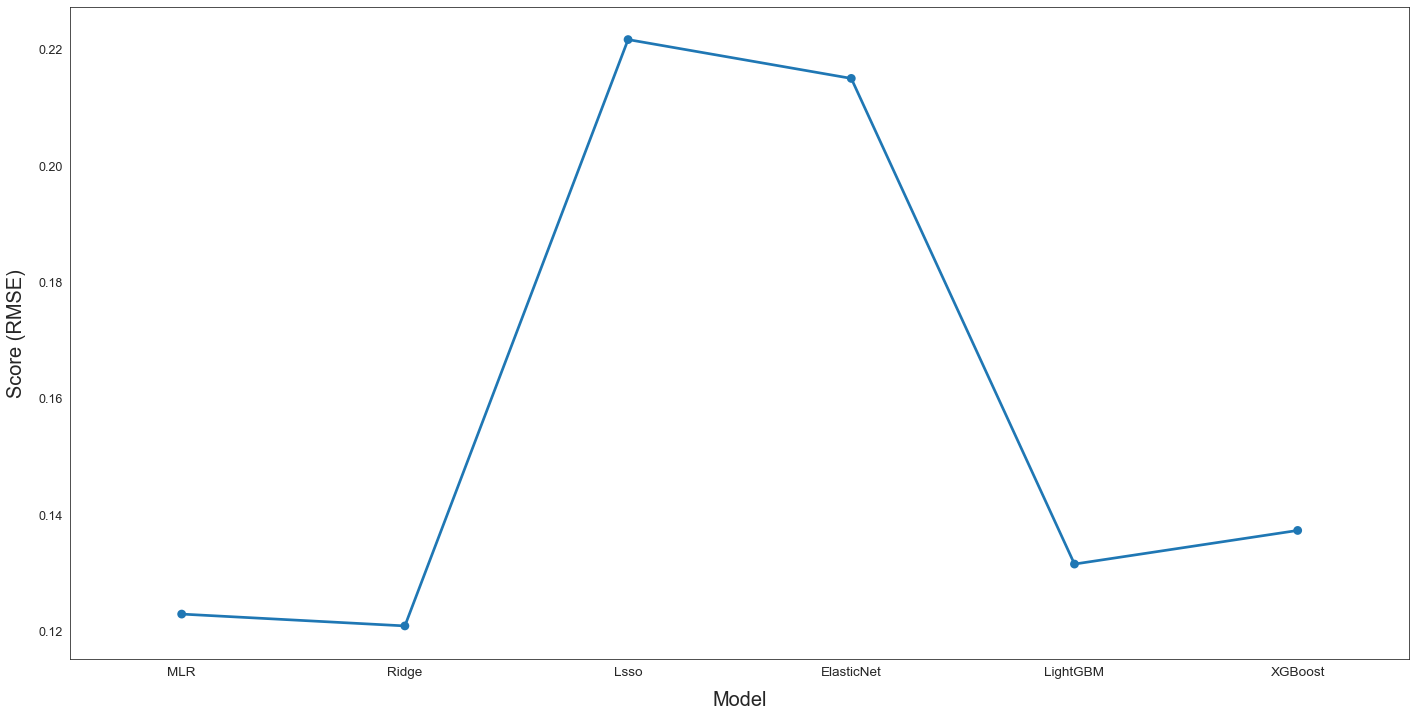

In [22]:
# Plot the predictions for each model
fig = plt.figure(figsize=(24, 12))
ax = sns.pointplot(x='Model', y='Score', data=model_scores_df)

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.show()